In [60]:
sc.version

u'1.6.1'

In [61]:
import numpy as np

In [62]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [63]:
# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")

In [64]:
import pyspark_csv as pycsv

In [144]:
#collisions = sc.textFile("/tmp/NYPD_Motor_Vehicle_Collisions5k.csv")
collisions = sc.textFile("/tmp/NYPD_Motor_Vehicle_Collisions.csv")
uberstaxi = sc.textFile("/tmp/uber-raw-data-apr14.csv")

In [145]:
collisions.take(2)

[u'DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5',
 u'11/10/2016,15:11,,,,,,MONROE STREET,,,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,,,,3559084,PASSENGER VEHICLE,,,,']

In [146]:
uberstaxi.take(2)

[u'"Date/Time","Lat","Lon","Base"',
 u'"4/1/2014 0:11:00",40.769,-73.9549,"B02512"']

collisions_header = collisions.first()
collisions_header_list = collisions_header.split(",")
collisions_body = collisions.filter(lambda line:line != collisions_header)
collisions_body = collisions_body.filter(lambda line : len(line.split(","))>29)
collisions_df = pycsv.csvToDataFrame(sqlContext, collisions_body, sep=",", columns=collisions_header_list)

In [147]:
def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

collisions_header = collisions.first()
collisions_header_list = collisions_header.split(",")
collisions_body = collisions.mapPartitionsWithIndex(skip_header)
# filter not valid rows
collisions_body = collisions_body.filter(lambda line : len(line.split(","))>29)

In [148]:
# create Spark DataFrame using pyspark-csv
collisions_df = pycsv.csvToDataFrame(sqlContext, collisions_body, sep=",", columns=collisions_header_list)

In [72]:
uber_header = uberstaxi.first()
uber_bodyP = uberstaxi.filter(lambda rec: rec != uber_header)
uber_body = uberstaxi.filter(lambda rec: rec != uber_header).map(lambda line:line.replace('"',''))

In [73]:
uber_bodyP.take(2), uber_body.take(2)

([u'"4/1/2014 0:11:00",40.769,-73.9549,"B02512"',
  u'"4/1/2014 0:17:00",40.7267,-74.0345,"B02512"'],
 [u'4/1/2014 0:11:00,40.769,-73.9549,B02512',
  u'4/1/2014 0:17:00,40.7267,-74.0345,B02512'])

In [74]:
uber_headerlistP = uber_header.split(",")
uber_headerlist = uber_header.replace('"','').split(',')
uber_headerlistP, uber_headerlist

([u'"Date/Time"', u'"Lat"', u'"Lon"', u'"Base"'],
 [u'Date/Time', u'Lat', u'Lon', u'Base'])

In [75]:
uber_df = pycsv.csvToDataFrame(sqlContext, uber_body, sep=",", columns=uber_headerlist)

In [76]:
uber_df.take(3)

[Row(Date/Time=datetime.datetime(2014, 4, 1, 0, 11), Lat=40.769, Lon=-73.9549, Base=u'B02512'),
 Row(Date/Time=datetime.datetime(2014, 4, 1, 0, 17), Lat=40.7267, Lon=-74.0345, Base=u'B02512'),
 Row(Date/Time=datetime.datetime(2014, 4, 1, 0, 21), Lat=40.7316, Lon=-73.9873, Base=u'B02512')]

In [77]:
uber_df.printSchema()

root
 |-- Date/Time: timestamp (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



In [78]:
#collisions_df.take(5)

In [79]:
collisions_df.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- TIME: timestamp (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string 

In [80]:
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import *

collisions_vec = collisions_df.select('NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','ZIP CODE','LATITUDE','LONGITUDE')
labelkill_df = collisions_df.select('NUMBER OF PERSONS INJURED')

In [81]:
oldColumns = collisions_vec.schema.names
newColumns = ["ninjured","nkill", "zip","latitude","longitude"]

In [82]:
data = collisions_vec
coldf = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), data)
coldf.printSchema()
#df.show()

root
 |-- ninjured: integer (nullable = true)
 |-- nkill: integer (nullable = true)
 |-- zip: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [83]:
#collisions_vec = collisions_vec[collisions_vec['ZIP CODE'] != 1 ]
#collisions_vec.take(3)
#labelkill_df.take(3)

In [84]:
coldf.take(3)
coldf = coldf[ coldf.zip > 0]
#coldf.describe().show()
coldf.take(3)

[Row(ninjured=0, nkill=0, zip=10458, latitude=40.8598744, longitude=-73.8932165),
 Row(ninjured=0, nkill=0, zip=10467, latitude=40.8787451, longitude=-73.8725452),
 Row(ninjured=0, nkill=0, zip=11208, latitude=40.6625139, longitude=-73.8720068)]

In [85]:
# assumes schema has 'age' column 
incidentdf = coldf.select('*', ( coldf.ninjured > 3 ).alias('incident'))
incidentdf.take(3)

[Row(ninjured=0, nkill=0, zip=10458, latitude=40.8598744, longitude=-73.8932165, incident=False),
 Row(ninjured=0, nkill=0, zip=10467, latitude=40.8787451, longitude=-73.8725452, incident=False),
 Row(ninjured=0, nkill=0, zip=11208, latitude=40.6625139, longitude=-73.8720068, incident=False)]

In [86]:
incidentdf.groupBy("incident").count().show()

+--------+-----+
|incident|count|
+--------+-----+
|    true|   16|
|   false| 2661|
+--------+-----+



In [87]:
temp = incidentdf.map(lambda line:LabeledPoint(int(line[5]),[line[1],line[2],line[3],line[4]]))
temp.take(5)

[LabeledPoint(0.0, [0.0,10458.0,40.8598744,-73.8932165]),
 LabeledPoint(0.0, [0.0,10467.0,40.8787451,-73.8725452]),
 LabeledPoint(0.0, [0.0,11208.0,40.6625139,-73.8720068]),
 LabeledPoint(0.0, [0.0,11215.0,40.6668449,-73.9948598]),
 LabeledPoint(0.0, [0.0,10002.0,40.7124088,-73.9780182])]

# Kmeans on Uber trip data

In [89]:
from pyspark.mllib.clustering import KMeans
import matplotlib.pyplot as plt
%matplotlib inline


In [96]:
train = uber_df.select("Lon","Lat").rdd.map(lambda l: [ l[0], l[1]])
train.take(3)

[[-73.9549, 40.769], [-74.0345, 40.7267], [-73.9873, 40.7316]]

In [97]:

clusters = KMeans.train(train, k=8, maxIterations=20, runs=20, initializationMode="random")

clusters.centers

[array([-73.98116992,  40.75597482]),
 array([-73.96481453,  40.68797067]),
 array([-74.20167303,  40.7005414 ]),
 array([-73.61633838,  40.97222233]),
 array([-73.77949983,  40.65584848]),
 array([-74.00029404,  40.72783221]),
 array([-73.87017595,  40.78127364]),
 array([-73.9588043 ,  40.78225725])]

In [138]:
def getCenterList(c):
    clist = []
    for cn in c:
        clist.append([cn[0] ,cn[1]])
    return clist
def getCenterDataFrame(c,headers):
    clist = []
    for cn in c:
        clist.append([cn[0] ,cn[1]])
    return pd.DataFrame(clist,columns=headers)

In [140]:
cl = getCenterDataFrame(clusters.centers,["Lon","Lat"])
cl

,Lon,Lat
0,-73.981170,40.755975
1,-73.964815,40.687971
2,-74.201673,40.700541
3,-73.616338,40.972222
4,-73.779500,40.655848
5,-74.000294,40.727832
6,-73.870176,40.781274
7,-73.958804,40.782257


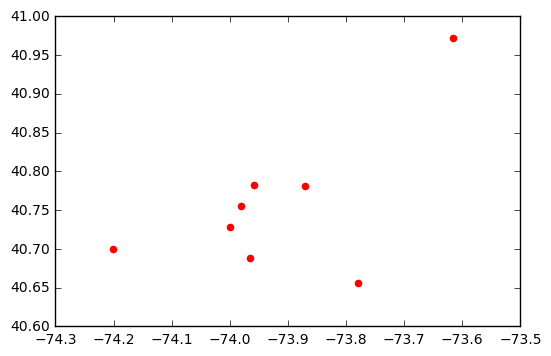

In [141]:
plt.scatter(cl.Lon ,cl.Lat,color="r")

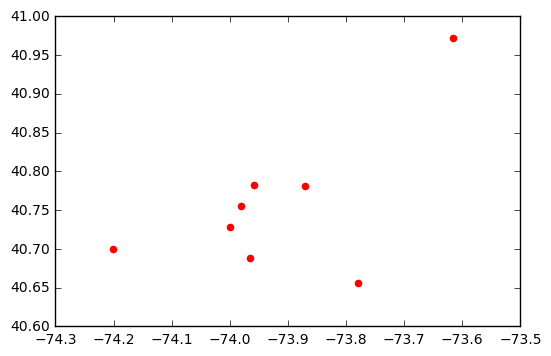

In [102]:

#import mplleaflet
def plotcenter(c):
    for cn in c:
        plt.scatter(cn[0] ,cn[1],color="r")      

plotcenter(clusters.centers)

#mplleaflet.display()

## Support Vector Machine 

In [57]:
transformedData = incidentdf.map(lambda line: LabeledPoint(int(line[5]),[line[1],line[2],line[3],line[4]]))

In [58]:
trainingData, testingData = transformedData.randomSplit([.8,.2],seed=1234)

In [59]:
half = transformedData.count()/2

In [ ]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
# Build the model
svmmodel = SVMWithSGD.train(trainingData, iterations=100)


In [ ]:
# Evaluating the model on training data
labelsAndPreds = trainingData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(trainingData.count())
print("Training Error = " + str(trainErr))


In [ ]:
prediObserRDDout = testingData.map(lambda row: (float(linearModel.predict(row.features[0])),row.label))
metrics = RegressionMetrics(prediObserRDDout)
metrics.rootMeanSquaredError

## Linear Regression with Stochastic Gradient Descent

In [30]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler


In [31]:
data = collisions_vec
coldf = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), data)
coldf = coldf[ coldf.zip > 0]
features = coldf.map(lambda row: row[1:])

In [32]:
standardizer = StandardScaler()
model = standardizer.fit(features)
features_transform = model.transform(features)
features_transform.take(5)

[DenseVector([18.431, 525.8509, -887.8766, 0.0]),
 DenseVector([18.4468, 526.0938, -887.6282, 0.0]),
 DenseVector([19.7528, 523.311, -887.6217, 0.0]),
 DenseVector([19.7651, 523.3667, -889.0979, 0.0]),
 DenseVector([17.6273, 523.9531, -888.8955, 0.0])]

In [33]:
lab = coldf.map(lambda row: row[0])
transformedData = lab.zip(features_transform)
transformedData = transformedData.map(lambda row: LabeledPoint(row[0],[row[1]]))

In [34]:
trainingData, testingData = transformedData.randomSplit([.8,.2],seed=1234)

In [ ]:
trainingData.take(3)

[LabeledPoint(0.0, [18.4309832161,525.850949051,-887.876595319,0.0]),
 LabeledPoint(0.0, [18.4468446475,526.093807739,-887.628215774,0.0]),
 LabeledPoint(0.0, [19.7527691611,523.310994933,-887.621746537,0.0])]

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
linearModel = LinearRegressionWithSGD.train(trainingData,100,.2)

In [ ]:
# Evaluating the model on training data
labelsAndPreds = trainingData.map(lambda p: (p.label, linearModel.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
print("Training Error = " + str(trainErr))

In [ ]:
prediObserRDDout = testingData.map(lambda row: (float(linearModel.predict(row.features[0])),row.label))
metrics = RegressionMetrics(prediObserRDDout)
metrics.rootMeanSquaredError

## Visualization

In [106]:
collisions_pd = collisions_df[ collisions_df['LATITUDE'] != 0 ]['LATITUDE','LONGITUDE','DATE','TIME','BOROUGH','ON STREET NAME','CROSS STREET NAME','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','CONTRIBUTING FACTOR VEHICLE 1' ].toPandas()

In [125]:
#collisions_pd
#collisions_pd.Longitude

In [108]:
collisions_pd.columns = ['Latitude', 'Longitude','Date', 'Time', 'Borough', 'On Street','Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

In [109]:
#divide dataset in accidents which are: fatal,non-lethal but with person damage, non of the above
killed_pd = collisions_pd[collisions_pd['Persons Killed']!=0]
injured_pd = collisions_pd[np.logical_and(collisions_pd['Persons Injured']!=0, collisions_pd['Persons Killed']==0)]
nothing_pd = collisions_pd[np.logical_and(collisions_pd['Persons Killed']==0, collisions_pd['Persons Injured']==0)]

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import seaborn as sns
import pandas as pd
#sns.set_style("white")

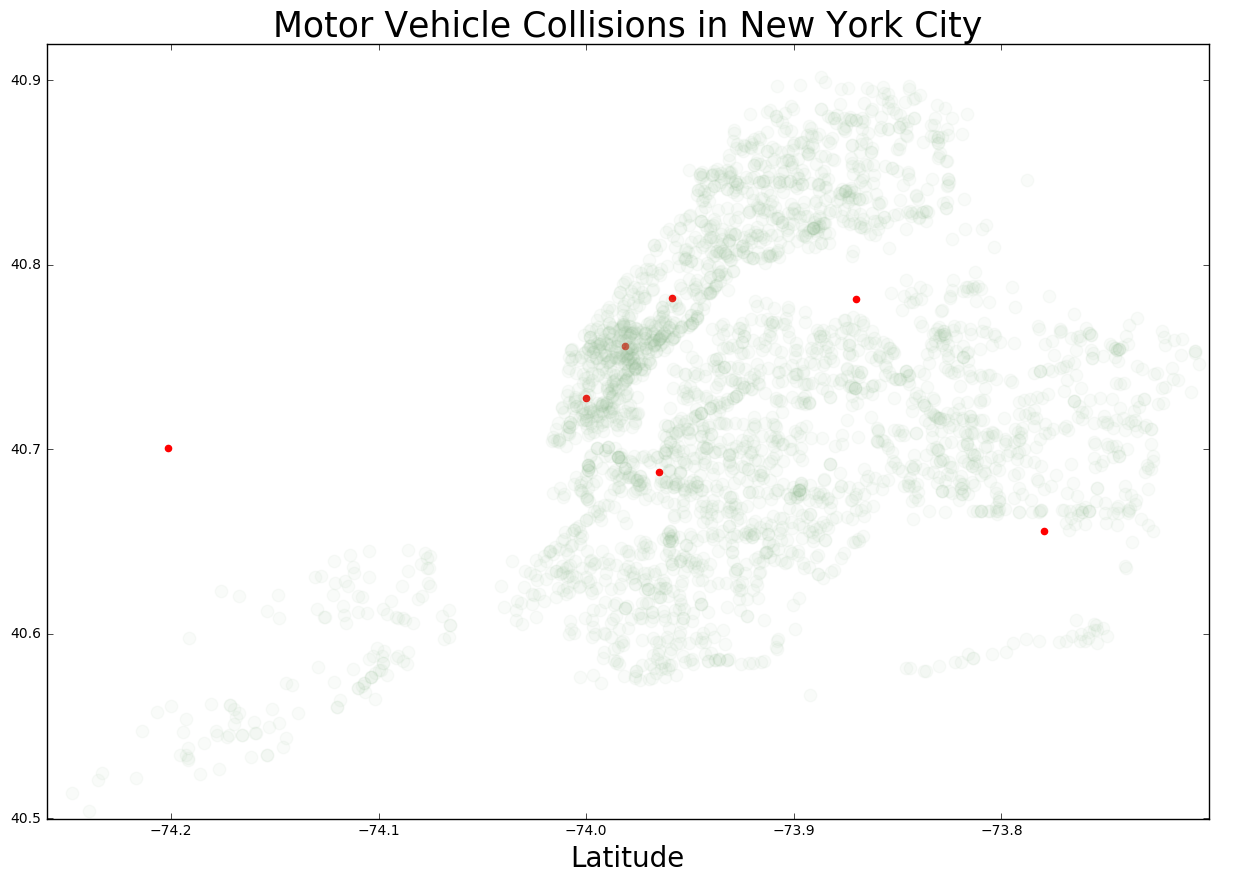

In [142]:
plt.figure(figsize=[15,10])
plt.scatter(cl.Lon ,cl.Lat,color="r")
plt.scatter(collisions_pd.Longitude, collisions_pd.Latitude, alpha=0.05, s=80, color='darkseagreen' )
plt.title('Motor Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.xlabel('Latitude',size=20)
plt.show()

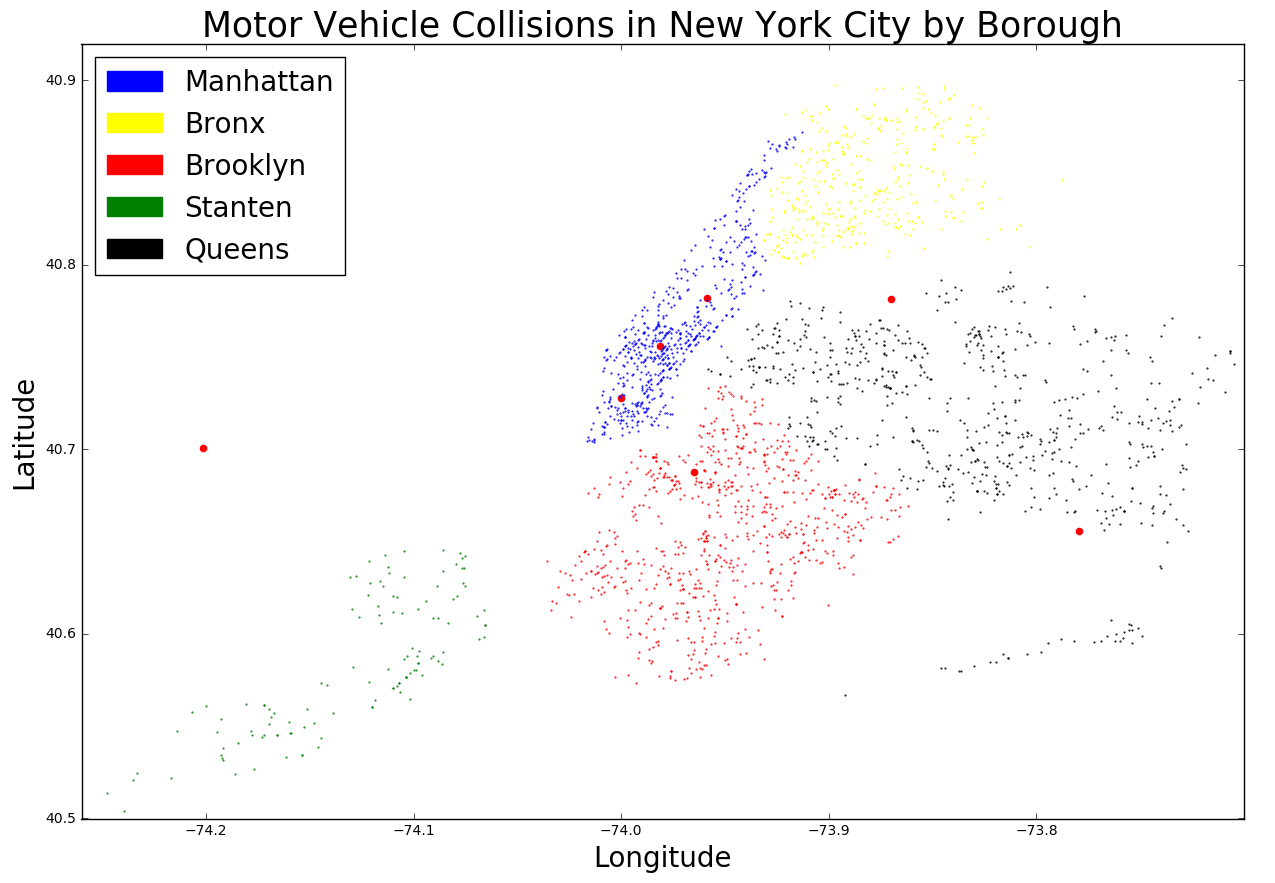

In [143]:
manhattan = collisions_pd[ collisions_pd[ 'Borough'] =='MANHATTAN']
bronx = collisions_pd[ collisions_pd[ 'Borough'] =='BRONX']
brooklyn = collisions_pd[ collisions_pd[ 'Borough'] =='BROOKLYN']
stanten = collisions_pd[ collisions_pd[ 'Borough'] =='STATEN ISLAND']
queens = collisions_pd[ collisions_pd[ 'Borough'] =='QUEENS']

plt.figure(figsize=(15,10), dpi =0.1)
plt.scatter(cl.Lon ,cl.Lat,color="r")
plt.scatter(manhattan.Longitude, manhattan.Latitude, s=1, color='blue', marker='.' )
plt.scatter(bronx.Longitude, bronx.Latitude, s=1, color='yellow', marker='.' )
plt.scatter(brooklyn.Longitude, brooklyn.Latitude, s=1, color='red', marker='.' )
plt.scatter(stanten.Longitude, stanten.Latitude, s=1, color='green', marker='.' )
plt.scatter(queens.Longitude, queens.Latitude, s=1, color='black', marker='.' )

bpatch = mpatches.Patch(label='Manhattan', color='blue')
ypatch = mpatches.Patch(label='Bronx', color='yellow')
rpatch = mpatches.Patch(label='Brooklyn', color='red')
gpatch = mpatches.Patch(label='Stanten', color='green')
blpatch = mpatches.Patch(label='Queens', color='black')

plt.legend([bpatch,ypatch,rpatch,gpatch,blpatch],
           ('Manhattan','Bronx','Brooklyn','Stanten','Queens'),
           loc='upper left',prop={'size':20})
plt.title('Motor Vehicle Collisions in New York City by Borough', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

## Total Number of collisions by borough

In [43]:
collisions_df.groupBy('BOROUGH').count().collect()

[Row(BOROUGH=u'MANHATTAN', count=177822),
 Row(BOROUGH=u'QUEENS', count=176846),
 Row(BOROUGH=u'STATEN ISLAND', count=32004),
 Row(BOROUGH=u'BROOKLYN', count=209998),
 Row(BOROUGH=None, count=80154),
 Row(BOROUGH=u'BRONX', count=88668)]

In [46]:
borough = collisions_df.groupBy('BOROUGH').count().sort('count').toPandas()

In [51]:
borough.sort_values('count',ascending=True)

,BOROUGH,count
0,STATEN ISLAND,32004
1,None,80154
2,BRONX,88668
3,QUEENS,176846
4,MANHATTAN,177822
5,BROOKLYN,209998


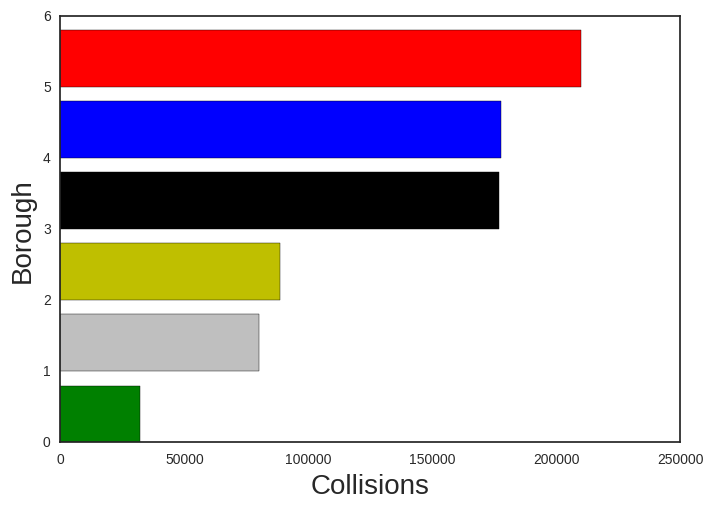

In [53]:
colors =  ['g','0.75','y','k','b','r']
plt.barh(range(6),borough.sort_values('count',ascending=True)['count'], color=colors)
plt.xlabel('Collisions',size=20)
plt.ylabel('Borough',size=20)
plt.yticks(range(6),)
plt.show()

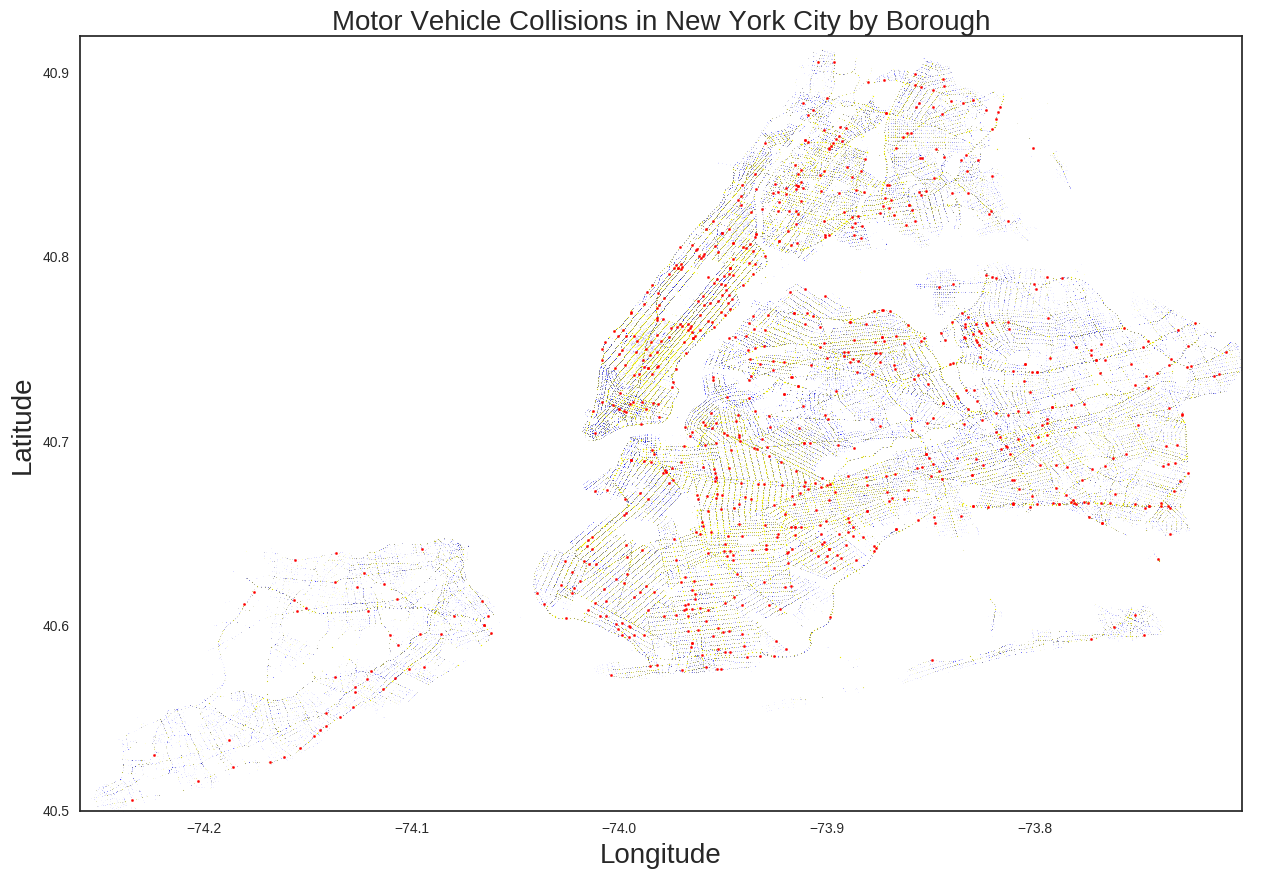

In [59]:
import mplleaflet
plt.figure(figsize=(15,10), dpi =0.1)

plt.scatter(nothing_pd.Longitude, nothing_pd.Latitude, alpha=0.04, s=1, color='blue', marker='.' )
plt.scatter(injured_pd.Longitude, injured_pd.Latitude, alpha=0.1, s=1, color='yellow', marker='.' )
plt.scatter(killed_pd.Longitude, killed_pd.Latitude, s=10, color='red', marker='.' )
plt.title('Motor Vehicle Collisions in New York City by Borough', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
#plt.show()
#mplleaflet.display()

In [60]:
collisions_header_list

[u'DATE',
 u'TIME',
 u'BOROUGH',
 u'ZIP CODE',
 u'LATITUDE',
 u'LONGITUDE',
 u'LOCATION',
 u'ON STREET NAME',
 u'CROSS STREET NAME',
 u'OFF STREET NAME',
 u'NUMBER OF PERSONS INJURED',
 u'NUMBER OF PERSONS KILLED',
 u'NUMBER OF PEDESTRIANS INJURED',
 u'NUMBER OF PEDESTRIANS KILLED',
 u'NUMBER OF CYCLIST INJURED',
 u'NUMBER OF CYCLIST KILLED',
 u'NUMBER OF MOTORIST INJURED',
 u'NUMBER OF MOTORIST KILLED',
 u'CONTRIBUTING FACTOR VEHICLE 1',
 u'CONTRIBUTING FACTOR VEHICLE 2',
 u'CONTRIBUTING FACTOR VEHICLE 3',
 u'CONTRIBUTING FACTOR VEHICLE 4',
 u'CONTRIBUTING FACTOR VEHICLE 5',
 u'UNIQUE KEY',
 u'VEHICLE TYPE CODE 1',
 u'VEHICLE TYPE CODE 2',
 u'VEHICLE TYPE CODE 3',
 u'VEHICLE TYPE CODE 4',
 u'VEHICLE TYPE CODE 5']

In [77]:
def getSchema(collisions_header_list):
    leave_in = ["Time","Street","Borough"]
    leave_out = ["ON STREET NAME", "OFF STREET NAME","CROSS STREET NAME","BOROUGH","DATE","TIME"] 
    fheader = [c for c in collisions_header_list if c not in leave_out] 
    return pyspark.sql.Row(*(leave_in + fheader ))

In [78]:
#collisions_pd[ 'Borough' ]

In [75]:
collisions_df = collisions_df.dropna(how='any', subset=['ON STREET NAME','BOROUGH'])


## Spatial and Temporal normalization using Spark

In [124]:
collisions_out_row = pyspark.sql.Row(*(["Time","Street","Borough"] + [c for c in collisions_header_list 
                                                                     if c not in ["ON STREET NAME", "OFF STREET NAME","CROSS STREET NAME","BOROUGH","DATE","TIME"] ] ))
collisions_out_index = list(collisions_out_row)

In [125]:
#x = ''.join(c for c in map(chr,range(256)) if not c.isalnum() )
#dict((ord(char),None) for char in x)
s1 = "EAST GUN HILL ROAD"
isinstance(s1.lower(),unicode)
s1.lower().translate(None,delchars).replace("road","rd").replace("east","e")

'egunhillrd'

In [225]:
delchars = ''.join(c for c in map(chr,range(256)) if not c.isalnum() )

deltable = dict((ord(char),None) for char in delchars)

normalization_code = {
    'avenue' : 'av',
    'ave' : 'av',
    'avnue' : 'av',
    'street' : 'st',
    'road' : 'rd',
    'boulevard' : 'blvd',
    'place' : 'pl',
    'plaza' : 'pl',
    'square' : 'sq',
    'drive' : 'dr',
    'lane' : 'ln',
    'parkway' : 'pkwy',
    'turnpike' : 'tp',
    'terrace' : 'ter',
    '1st' : '1',
    '2sd' : '2',
    '3rd' : '3',
    '1th' : '1',
    '2th' : '2',
    '3th' : '3',
    '9th' : '9',
    '0th' : '0',
    'east' : 'e',
    'west' : 'w',
    'north' : 'n',
    'south' : 's'    
}

def normalize_street(s):
    #lowercase
    s = s.lower()
    
    #delete all alpha-numeric characters
    if isinstance(s,unicode):
        s = s.translate(deltable)
    else:
        s = s.translate(None,delchars) #Python 2
    
    #replace common abbrevations
    for k in sorted(normalization_code.keys()):
        s = s.replace(k, normalization_code[k])
    
    #only keep ascii chars
    s = s.encode('ascii', errors='ignore').decode()
    
    return s
    
#def get_spatial(row):
#    loc = normalize_street(row.__getattribute__("ON STREET NAME"))
#    borough = row.__getattribute__("BOROUGH").lower()
#    return [ loc, borough ]

def get_spatial(row):
    loc = normalize_street(row.__getattr__("ON STREET NAME"))
    borough = row.__getattr__("BOROUGH").lower()
    return [ loc, borough ]

def get_temporal(row):
    from datetime import datetime
    return [ datetime( row.DATE.year, row.DATE.month, row.DATE.day, row.DATE.hour )]

def get_rest(row):
    return [ row.__getattr__(column) for column in collisions_header_list
           if column not in ["ON STREET NAME","OFF STREET NAME","CROSS STREET NAME","BOROUGH","DATE","TIME"] ]

## Map the related columns to the dataframe

In [235]:
collisions_out = collisions_df.map( lambda row : 
                collisions_out_row(*( get_temporal(row) + get_spatial(row) + get_rest(row) ) ) )

In [238]:
#
#Debugging code
#[column for column in collisions_header_list
#           if column not in ["ON STREET NAME","OFF STREET NAME","CROSS STREET NAME","BOROUGH","DATE","TIME"] ]
#collisions_out = collisions_df.map( lambda row : collisions_out_row(*( get_temporal(row) + get_spatial(row) ) ) )
#collisions_out = collisions_df.map( lambda row : collisions_out_row(*( get_rest(row) ) ) )
#x3 = collisions_df
#collisions_out = map( lambda row : collisions_out_row(*( get_spatial(row) ) ), x3 )
#collisions_out.take(3)
#

In [242]:
from pyspark.sql.functions import desc

collisions_out_df = collisions_out.toDF(sampleRatio=1)

factor = collisions_out_df.groupBy('CONTRIBUTING FACTOR VEHICLE 1').count().sort(desc('count')).toPandas()

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


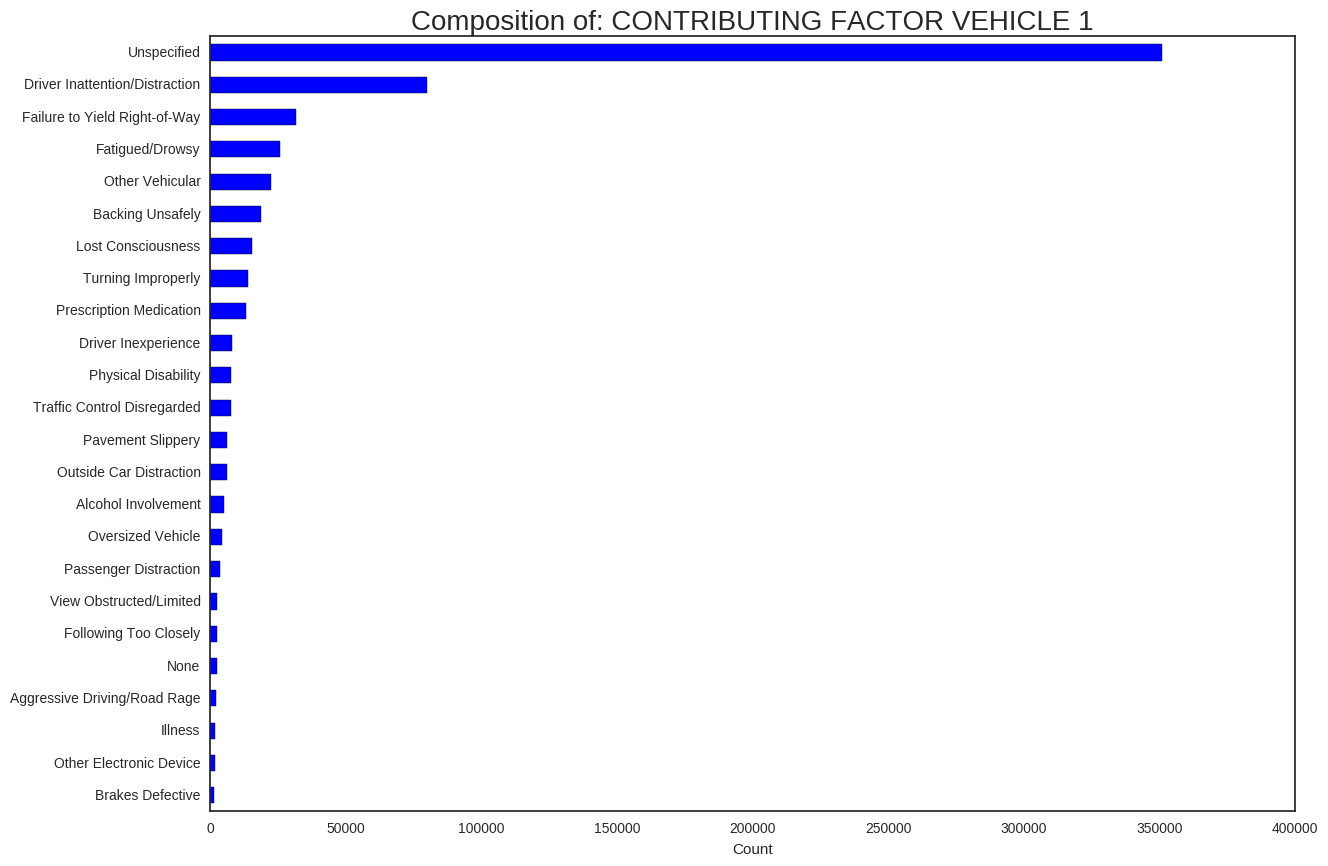

In [243]:
factor = factor[0:24].sort(ascending=False)
factor.plot(kind='barh',legend = False, color='blue', figsize=(14,10))
plt.title('Composition of: ' + 'CONTRIBUTING FACTOR VEHICLE 1' ,size=20 )
plt.xlabel('Count')
plt.yticks( range( len(factor))[::-1],factor['CONTRIBUTING FACTOR VEHICLE 1'][::-1])
plt.show()

In [247]:
#factor
collisions_out_df.groupBy("VEHICLE TYPE CODE 1").count().collect()

[Row(VEHICLE TYPE CODE 1=u'TAXI', count=29365),
 Row(VEHICLE TYPE CODE 1=u'LARGE COM VEH(6 OR MORE TIRES)', count=9595),
 Row(VEHICLE TYPE CODE 1=u'PASSENGER VEHICLE', count=360596),
 Row(VEHICLE TYPE CODE 1=u'SCOOTER', count=251),
 Row(VEHICLE TYPE CODE 1=u'UNKNOWN', count=16689),
 Row(VEHICLE TYPE CODE 1=u'PEDICAB', count=21),
 Row(VEHICLE TYPE CODE 1=u'MOTORCYCLE', count=3507),
 Row(VEHICLE TYPE CODE 1=u'PICK-UP TRUCK', count=9577),
 Row(VEHICLE TYPE CODE 1=u'SPORT UTILITY / STATION WAGON', count=142079),
 Row(VEHICLE TYPE CODE 1=u'VAN', count=20912),
 Row(VEHICLE TYPE CODE 1=u'BUS', count=11863),
 Row(VEHICLE TYPE CODE 1=u'SMALL COM VEH(4 TIRES)', count=11015),
 Row(VEHICLE TYPE CODE 1=u'AMBULANCE', count=1943),
 Row(VEHICLE TYPE CODE 1=u'OTHER', count=18697),
 Row(VEHICLE TYPE CODE 1=u'BICYCLE', count=1027),
 Row(VEHICLE TYPE CODE 1=u'FIRE TRUCK', count=654),
 Row(VEHICLE TYPE CODE 1=None, count=1893),
 Row(VEHICLE TYPE CODE 1=u'LIVERY VEHICLE', count=7767)]

In [250]:
from collections import Counter

vehicletype, vehicletypecoderange = 'VEHICLE TYPE CODE ', range(1,6)
grouping = {
    'TAXI' : 'Taxi',
    'AMBULANCE' : 'Other',
    'BYCYCLE' : 'Other',
    'BUS' : 'Bus',
    'FIRE TRUCK' : 'Other',
    'LARGE COM VEH(6 OR MORE TIRES)' : 'Truck' ,
    'SCOOTER' : 'Other',
    'UNKNOWN' : 'Other',
    'PEDICAB' : 'Other',
    'MOTORCYCLE': 'Other',
    'PICK-UP TRUCK': 'Truck',
    'SPORT UTILITY / STATION WAGON': 'Auto',
    'VAN' : 'Auto',
    'SMALL COM VEH(4 TIRES)': 'Truck' ,
    'OTHER': 'Other',
    'LIVERY VEHICLE': 'Truck',
    'UNSPECIFIED': 'Other',
    None:None
}

collision_out_categories = collisions_out.map(lambda row:
                                            collisions_out_row(*[grouping[row[i]] if collisions_out_index[i].startswith("VEHICLE TYPE CODE")
                                                                 else row[i]for i in range(len(row))])
                                                              )

In [252]:
collisions_transformed_row  = pyspark.sql.Row(*( ["Time", "Street", "Borough", "Injured", "Killed", "Auto", "Bus", "Truck", "Taxi", "Other"]))

#Skipped accidents by car type 

## Collisions by street

In [253]:
##
data1 = collisions_out_df[['Borough', 'Street', 'LATITUDE', 'LONGITUDE']].toPandas()

In [259]:
data1[:10]

,Borough,Street,LATITUDE,LONGITUDE
0,bronx,websterav,40.859874,-73.893216
1,bronx,egunhillrd,40.878745,-73.872545
2,brooklyn,wortmanav,40.662514,-73.872007
3,brooklyn,3av,40.666845,-73.994860
4,manhattan,fdrdr,40.712409,-73.978018
5,manhattan,1av,40.794697,-73.936360
6,manhattan,w135st,40.820098,-73.955076
7,queens,94st,40.770313,-73.876024
8,manhattan,w55st,40.769982,-73.994646
9,queens,77rd,40.714132,-73.834941


In [254]:
collisions_out_df.first()

Row(Time=datetime.datetime(2016, 11, 10, 0, 0), Street=u'websterav', Borough=u'bronx', ZIP CODE=10458, LATITUDE=40.8598744, LONGITUDE=-73.8932165, LOCATION=u'(40.8598744, -73.8932165)', NUMBER OF PERSONS INJURED=0, NUMBER OF PERSONS KILLED=0, NUMBER OF PEDESTRIANS INJURED=0, NUMBER OF PEDESTRIANS KILLED=0, NUMBER OF CYCLIST INJURED=0, NUMBER OF CYCLIST KILLED=0, NUMBER OF MOTORIST INJURED=0, NUMBER OF MOTORIST KILLED=0, CONTRIBUTING FACTOR VEHICLE 1=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 2=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 3=None, CONTRIBUTING FACTOR VEHICLE 4=None, CONTRIBUTING FACTOR VEHICLE 5=None, UNIQUE KEY=3557464, VEHICLE TYPE CODE 1=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 2=None, VEHICLE TYPE CODE 3=None, VEHICLE TYPE CODE 4=None, VEHICLE TYPE CODE 5=None)

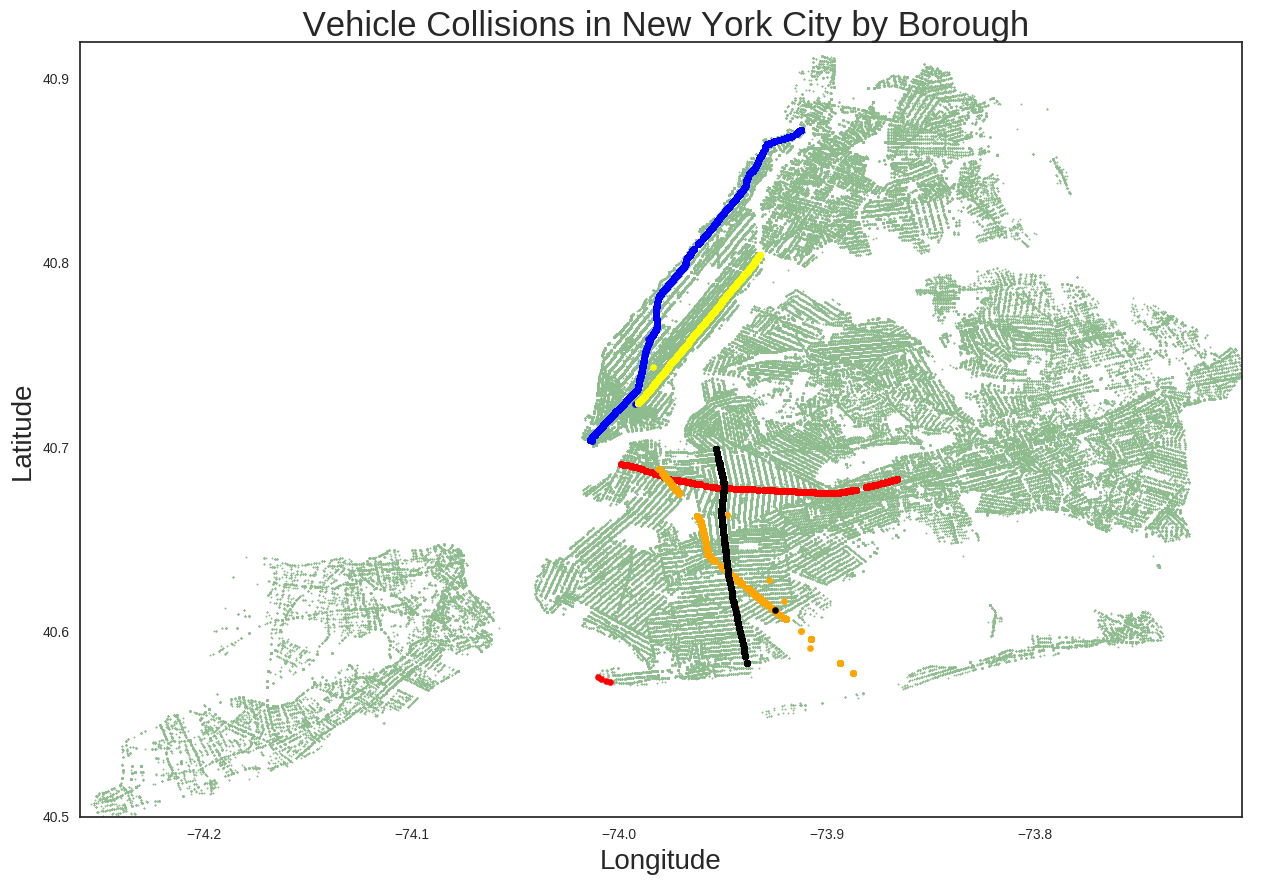

In [263]:
plt.figure(figsize=(15,10))
col1 = data1[np.logical_and(data1['Street']=='atlanticav', data1['Borough']=='brooklyn')]
col2 = data1[np.logical_and(data1['Street']=='brdway', data1['Borough']=='manhattan') ]
col3 = data1[np.logical_and(data1['Street']=='flatbushav', data1['Borough']=='brooklyn') ]
col4 = data1[np.logical_and(data1['Street']=='2av', data1['Borough']=='manhattan') ]
col5 = data1[np.logical_and(data1['Street']=='nostrandav', data1['Borough']=='brooklyn') ]

plt.scatter(data1.LONGITUDE,data1.LATITUDE,s=1, color='darkseagreen')
plt.scatter(col1.LONGITUDE,col1.LATITUDE,s=20, color='red')
plt.scatter(col2.LONGITUDE,col2.LATITUDE,s=20, color='blue')
plt.scatter(col3.LONGITUDE,col3.LATITUDE,s=20, color='orange')
plt.scatter(col4.LONGITUDE,col4.LATITUDE,s=20, color='yellow')
plt.scatter(col5.LONGITUDE,col5.LATITUDE,s=20, color='black')

plt.title(' Vehicle Collisions in New York City by Borough', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

